# Librerias

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL
from PIL import Image
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

torch.manual_seed(123)
random.seed(123)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# Dataset

In [2]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((78, 78)),
    transforms.ToTensor(),  # Convertir a tensor de PyTorch
    #transforms.Normalize((0.4915, 0.4823, 0.4468),
                             #(0.2470, 0.2435, 0.2616))
])



# Crear dataset personalizado de PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = ['Under', 'Over', 'Empty', 'OK']
        self.imgs = []
        
        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.imgs.append((img_path, i))  # Añadir ruta de imagen y su label
        
        # Mezclar las imágenes antes de dividir el dataset
        random.shuffle(self.imgs)
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        return img, label

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Crear el dataset personalizado
dataset = CustomDataset('/content/drive/MyDrive/DatasetTFG/labeled')

In [4]:
#Trabajamos en la GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [7]:
dataset_1 = torch.utils.data.Subset(dataset, range(10000)) # Para un primer intento, dataset de 100 imagenes 

# Definir tamaño de los conjuntos de entrenamiento y validación
train_size = int(0.8 * len(dataset_1))
val_size = len(dataset_1) - train_size

# Dividir el dataset en conjuntos de entrenamiento y validación de manera aleatoria
train_data, val_data = random_split(dataset_1, [train_size, val_size])

In [8]:
# Create datasets for training and validation
image_datasets = {'train': train_data, 'val': val_data}

# Create dataloaders for training and validation
batch_size = 8
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [9]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./content/drive/MyDrive/Dataset_hymenoptera/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 11

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train': #Se introduce para la variación de hiperparametros
              scheduler.step()
              print(optimizer_ft.state_dict()['param_groups'][0]['lr'],epoch,sep = "->epoch ")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_history,train_acc_history,train_loss_history

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

# Algoritmo de optimización y learning rate

## SDG

### StepLR

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 2, gamma=0.3, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.05->epoch 0
train Loss: 1.8966 Acc: 0.4253
val Loss: 0.9472 Acc: 0.5265

Epoch 1/29
----------
0.015->epoch 1
train Loss: 0.8760 Acc: 0.5721
val Loss: 0.8127 Acc: 0.6735

Epoch 2/29
----------
0.015->epoch 2
train Loss: 0.6456 Acc: 0.7456
val Loss: 0.5730 Acc: 0.7910

Epoch 3/29
----------
0.0045->epoch 3
train Loss: 0.6011 Acc: 0.7640
val Loss: 0.9239 Acc: 0.7300

Epoch 4/29
----------
0.0045->epoch 4
train Loss: 0.5433 Acc: 0.7883
val Loss: 0.5164 Acc: 0.8215

Epoch 5/29
----------
0.0013499999999999999->epoch 5
train Loss: 0.5337 Acc: 0.7919
val Loss: 1.3319 Acc: 0.7380

Epoch 6/29
----------
0.0013499999999999999->epoch 6
train Loss: 0.5187 Acc: 0.7983
val Loss: 0.5035 Acc: 0.8175

Epoch 7/29
----------
0.0004049999999999999->epoch 7
train Loss: 0.5119 Acc: 0.8029
val Loss: 0.8277 Acc: 0.7590

Epoch 8/29
----------
0.0004049999999999999->epoch 8
train Loss: 0.5094 Acc: 0.7971
val Loss: 0.4741 Acc: 0.8125

Epoch 9/29
----------
0.00012149999999999997->epoch 9

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 3, gamma=0.6, last_epoch=- 1, verbose=False) #gamma controla cuanto se baja y epochs cada cuantas epocas

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.005->epoch 0
train Loss: 1.0603 Acc: 0.7014
val Loss: 0.5403 Acc: 0.7920

Epoch 1/29
----------
0.005->epoch 1
train Loss: 0.6404 Acc: 0.7799
val Loss: 0.5142 Acc: 0.7960

Epoch 2/29
----------
0.003->epoch 2
train Loss: 0.5908 Acc: 0.7926
val Loss: 0.4723 Acc: 0.8190

Epoch 3/29
----------
0.003->epoch 3
train Loss: 0.5138 Acc: 0.8197
val Loss: 0.4257 Acc: 0.8310

Epoch 4/29
----------
0.003->epoch 4
train Loss: 0.4644 Acc: 0.8297
val Loss: 0.5712 Acc: 0.7980

Epoch 5/29
----------
0.0018->epoch 5
train Loss: 0.4497 Acc: 0.8401
val Loss: 0.4557 Acc: 0.8230

Epoch 6/29
----------
0.0018->epoch 6
train Loss: 0.3927 Acc: 0.8508
val Loss: 0.7770 Acc: 0.7575

Epoch 7/29
----------
0.0018->epoch 7
train Loss: 0.3815 Acc: 0.8558
val Loss: 0.4348 Acc: 0.8260

Epoch 8/29
----------
0.00108->epoch 8
train Loss: 0.3587 Acc: 0.8619
val Loss: 0.4442 Acc: 0.8320

Epoch 9/29
----------
0.00108->epoch 9
train Loss: 0.3238 Acc: 0.8765
val Loss: 0.4847 Acc: 0.8205

Epoch 10/29
-

### ExponentialLR

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, 0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, 0.9, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.0045000000000000005->epoch 0
train Loss: 1.1814 Acc: 0.6639
val Loss: 0.5549 Acc: 0.8205

Epoch 1/29
----------
0.004050000000000001->epoch 1
train Loss: 0.7134 Acc: 0.7642
val Loss: 0.4359 Acc: 0.8270

Epoch 2/29
----------
0.0036450000000000007->epoch 2
train Loss: 0.6044 Acc: 0.7831
val Loss: 0.4212 Acc: 0.8310

Epoch 3/29
----------
0.003280500000000001->epoch 3
train Loss: 0.5272 Acc: 0.8063
val Loss: 0.5234 Acc: 0.7955

Epoch 4/29
----------
0.002952450000000001->epoch 4
train Loss: 0.5049 Acc: 0.8180
val Loss: 0.4604 Acc: 0.8205

Epoch 5/29
----------
0.002657205000000001->epoch 5
train Loss: 0.4667 Acc: 0.8329
val Loss: 0.4324 Acc: 0.8280

Epoch 6/29
----------
0.002391484500000001->epoch 6
train Loss: 0.4383 Acc: 0.8346
val Loss: 0.4431 Acc: 0.8290

Epoch 7/29
----------
0.002152336050000001->epoch 7
train Loss: 0.4250 Acc: 0.8419
val Loss: 0.4614 Acc: 0.8210

Epoch 8/29
----------
0.001937102445000001->epoch 8
train Loss: 0.4014 Acc: 0.8488
val Loss: 0

## Adam

### StepLR

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 3, gamma=0.1, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.1->epoch 0
train Loss: 1.5461 Acc: 0.5429
val Loss: 0.7941 Acc: 0.7840

Epoch 1/29
----------
0.1->epoch 1
train Loss: 0.6994 Acc: 0.7340
val Loss: 0.6450 Acc: 0.7425

Epoch 2/29
----------
0.010000000000000002->epoch 2
train Loss: 0.6299 Acc: 0.7569
val Loss: 0.4728 Acc: 0.8205

Epoch 3/29
----------
0.010000000000000002->epoch 3
train Loss: 0.4807 Acc: 0.8131
val Loss: 0.4797 Acc: 0.8305

Epoch 4/29
----------
0.010000000000000002->epoch 4
train Loss: 0.4500 Acc: 0.8247
val Loss: 0.4313 Acc: 0.8255

Epoch 5/29
----------
0.0010000000000000002->epoch 5
train Loss: 0.4404 Acc: 0.8307
val Loss: 0.6247 Acc: 0.7560

Epoch 6/29
----------
0.0010000000000000002->epoch 6
train Loss: 0.4129 Acc: 0.8374
val Loss: 0.4267 Acc: 0.8255

Epoch 7/29
----------
0.0010000000000000002->epoch 7
train Loss: 0.4070 Acc: 0.8425
val Loss: 0.4270 Acc: 0.8340

Epoch 8/29
----------
0.00010000000000000003->epoch 8
train Loss: 0.4107 Acc: 0.8406
val Loss: 0.4255 Acc: 0.8305

Epoch 9/29
-

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 3, gamma=0.1, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.005->epoch 0
train Loss: 0.9013 Acc: 0.6663
val Loss: 0.4807 Acc: 0.8170

Epoch 1/29
----------
0.005->epoch 1
train Loss: 0.5896 Acc: 0.7760
val Loss: 0.4890 Acc: 0.8090

Epoch 2/29
----------
0.0005->epoch 2
train Loss: 0.5302 Acc: 0.8003
val Loss: 0.4814 Acc: 0.8120

Epoch 3/29
----------
0.0005->epoch 3
train Loss: 0.4518 Acc: 0.8241
val Loss: 0.4355 Acc: 0.8250

Epoch 4/29
----------
0.0005->epoch 4
train Loss: 0.4131 Acc: 0.8400
val Loss: 0.4214 Acc: 0.8320

Epoch 5/29
----------
5e-05->epoch 5
train Loss: 0.3951 Acc: 0.8480
val Loss: 0.4360 Acc: 0.8305

Epoch 6/29
----------
5e-05->epoch 6
train Loss: 0.3715 Acc: 0.8585
val Loss: 0.4170 Acc: 0.8390

Epoch 7/29
----------
5e-05->epoch 7
train Loss: 0.3638 Acc: 0.8609
val Loss: 0.4220 Acc: 0.8360

Epoch 8/29
----------
5e-06->epoch 8
train Loss: 0.3600 Acc: 0.8603
val Loss: 0.4138 Acc: 0.8340

Epoch 9/29
----------
5e-06->epoch 9
train Loss: 0.3536 Acc: 0.8599
val Loss: 0.4180 Acc: 0.8340

Epoch 10/29
-----

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 5, gamma=0.8, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.1->epoch 0
train Loss: 1.5415 Acc: 0.5425
val Loss: 0.7658 Acc: 0.7270

Epoch 1/29
----------
0.1->epoch 1
train Loss: 0.7132 Acc: 0.7236
val Loss: 0.6944 Acc: 0.7145

Epoch 2/29
----------
0.1->epoch 2
train Loss: 0.6431 Acc: 0.7554
val Loss: 0.5518 Acc: 0.7935

Epoch 3/29
----------
0.1->epoch 3
train Loss: 0.5764 Acc: 0.7776
val Loss: 0.5682 Acc: 0.8005

Epoch 4/29
----------
0.08000000000000002->epoch 4
train Loss: 0.5817 Acc: 0.7771
val Loss: 0.4783 Acc: 0.8115

Epoch 5/29
----------
0.08000000000000002->epoch 5
train Loss: 0.5115 Acc: 0.8060
val Loss: 0.4950 Acc: 0.8095

Epoch 6/29
----------
0.08000000000000002->epoch 6
train Loss: 0.5140 Acc: 0.7998
val Loss: 0.5390 Acc: 0.7815

Epoch 7/29
----------
0.08000000000000002->epoch 7
train Loss: 0.5332 Acc: 0.8016


### Exponential

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.005)


scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, 0.1, last_epoch=- 1, verbose=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.0005->epoch 0
train Loss: 0.9337 Acc: 0.6518
val Loss: 0.5052 Acc: 0.8165

Epoch 1/29
----------
5e-05->epoch 1
train Loss: 0.5494 Acc: 0.7898
val Loss: 0.4465 Acc: 0.8215

Epoch 2/29
----------
5e-06->epoch 2
train Loss: 0.5169 Acc: 0.7968
val Loss: 0.4412 Acc: 0.8310

Epoch 3/29
----------
5.000000000000001e-07->epoch 3
train Loss: 0.5025 Acc: 0.8066
val Loss: 0.4344 Acc: 0.8320

Epoch 4/29
----------
5.000000000000001e-08->epoch 4
train Loss: 0.4976 Acc: 0.8049
val Loss: 0.4416 Acc: 0.8235

Epoch 5/29
----------
5.000000000000002e-09->epoch 5
train Loss: 0.4980 Acc: 0.8075
val Loss: 0.4324 Acc: 0.8300

Epoch 6/29
----------
5.000000000000002e-10->epoch 6
train Loss: 0.5126 Acc: 0.7989
val Loss: 0.4338 Acc: 0.8255

Epoch 7/29
----------
5.000000000000003e-11->epoch 7
train Loss: 0.5126 Acc: 0.8036
val Loss: 0.4352 Acc: 0.8290

Epoch 8/29
----------
5.000000000000003e-12->epoch 8
train Loss: 0.5147 Acc: 0.8004
val Loss: 0.4505 Acc: 0.8155

Epoch 9/29
----------

## Adadelta

### Step

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 3, gamma=0.1, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.05->epoch 0
train Loss: 0.5923 Acc: 0.7704
val Loss: 0.4830 Acc: 0.8165

Epoch 1/29
----------
0.05->epoch 1
train Loss: 0.4495 Acc: 0.8304
val Loss: 0.5154 Acc: 0.8335

Epoch 2/29
----------
0.005000000000000001->epoch 2
train Loss: 0.3929 Acc: 0.8511
val Loss: 0.5049 Acc: 0.8285

Epoch 3/29
----------
0.005000000000000001->epoch 3
train Loss: 0.2701 Acc: 0.9014
val Loss: 0.5016 Acc: 0.8295

Epoch 4/29
----------
0.005000000000000001->epoch 4
train Loss: 0.2227 Acc: 0.9158
val Loss: 0.5209 Acc: 0.8285

Epoch 5/29
----------
0.0005000000000000001->epoch 5
train Loss: 0.2005 Acc: 0.9313
val Loss: 0.5550 Acc: 0.8300

Epoch 6/29
----------
0.0005000000000000001->epoch 6
train Loss: 0.1873 Acc: 0.9340
val Loss: 0.5700 Acc: 0.8280

Epoch 7/29
----------
0.0005000000000000001->epoch 7
train Loss: 0.1814 Acc: 0.9371
val Loss: 0.5836 Acc: 0.8285

Epoch 8/29
----------
5.0000000000000016e-05->epoch 8
train Loss: 0.1729 Acc: 0.9399
val Loss: 0.5748 Acc: 0.8270

Epoch 9/29

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 3, gamma=0.6, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.005->epoch 0
train Loss: 0.6636 Acc: 0.7356
val Loss: 0.5128 Acc: 0.7865

Epoch 1/29
----------
0.005->epoch 1
train Loss: 0.4980 Acc: 0.8045
val Loss: 0.4634 Acc: 0.8065

Epoch 2/29
----------
0.003->epoch 2
train Loss: 0.4485 Acc: 0.8253
val Loss: 0.4695 Acc: 0.8120

Epoch 3/29
----------
0.003->epoch 3
train Loss: 0.3980 Acc: 0.8481
val Loss: 0.4789 Acc: 0.8030

Epoch 4/29
----------
0.003->epoch 4
train Loss: 0.3643 Acc: 0.8556
val Loss: 0.4768 Acc: 0.8085

Epoch 5/29
----------
0.0018->epoch 5
train Loss: 0.3515 Acc: 0.8669
val Loss: 0.4870 Acc: 0.8105

Epoch 6/29
----------
0.0018->epoch 6
train Loss: 0.3292 Acc: 0.8720
val Loss: 0.4959 Acc: 0.8080

Epoch 7/29
----------
0.0018->epoch 7
train Loss: 0.3207 Acc: 0.8841
val Loss: 0.4903 Acc: 0.8175

Epoch 8/29
----------
0.00108->epoch 8
train Loss: 0.3024 Acc: 0.8865
val Loss: 0.5122 Acc: 0.8080

Epoch 9/29
----------
0.00108->epoch 9
train Loss: 0.2946 Acc: 0.8885
val Loss: 0.5147 Acc: 0.8080

Epoch 10/29
-

### Exponential

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adadelta(params_to_update, lr=0.05)


scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, 0.1, last_epoch=- 1, verbose=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.005000000000000001->epoch 0
train Loss: 0.5867 Acc: 0.7700
val Loss: 0.4977 Acc: 0.8080

Epoch 1/29
----------
0.0005000000000000001->epoch 1
train Loss: 0.4030 Acc: 0.8465
val Loss: 0.4489 Acc: 0.8345

Epoch 2/29
----------
5.0000000000000016e-05->epoch 2
train Loss: 0.3802 Acc: 0.8553
val Loss: 0.4485 Acc: 0.8350

Epoch 3/29
----------
5.000000000000002e-06->epoch 3
train Loss: 0.3769 Acc: 0.8590
val Loss: 0.4487 Acc: 0.8335

Epoch 4/29
----------
5.000000000000002e-07->epoch 4
train Loss: 0.3698 Acc: 0.8633
val Loss: 0.4675 Acc: 0.8380

Epoch 5/29
----------
5.0000000000000024e-08->epoch 5
train Loss: 0.3689 Acc: 0.8636
val Loss: 0.4494 Acc: 0.8310

Epoch 6/29
----------
5.0000000000000026e-09->epoch 6
train Loss: 0.3808 Acc: 0.8530
val Loss: 0.4518 Acc: 0.8370

Epoch 7/29
----------
5.000000000000002e-10->epoch 7
train Loss: 0.3750 Acc: 0.8581
val Loss: 0.4514 Acc: 0.8355

Epoch 8/29
----------
5.000000000000003e-11->epoch 8
train Loss: 0.3743 Acc: 0.8555
va

## Adagrad

### Step

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 5, gamma=0.1, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.05->epoch 0
train Loss: 0.9954 Acc: 0.6204
val Loss: 1.4657 Acc: 0.7210

Epoch 1/29
----------
0.05->epoch 1
train Loss: 0.5943 Acc: 0.7668
val Loss: 0.9715 Acc: 0.7525

Epoch 2/29
----------
0.05->epoch 2
train Loss: 0.5438 Acc: 0.7909
val Loss: 0.4582 Acc: 0.8350

Epoch 3/29
----------
0.05->epoch 3
train Loss: 0.4903 Acc: 0.8141
val Loss: 1.9645 Acc: 0.7520

Epoch 4/29
----------
0.005000000000000001->epoch 4
train Loss: 0.4597 Acc: 0.8211
val Loss: 1.3533 Acc: 0.7515

Epoch 5/29
----------
0.005000000000000001->epoch 5
train Loss: 0.4176 Acc: 0.8443
val Loss: 3.5414 Acc: 0.7420

Epoch 6/29
----------
0.005000000000000001->epoch 6
train Loss: 0.4088 Acc: 0.8439
val Loss: 1.6843 Acc: 0.7640

Epoch 7/29
----------
0.005000000000000001->epoch 7
train Loss: 0.3995 Acc: 0.8475
val Loss: 2.6571 Acc: 0.7560

Epoch 8/29
----------
0.005000000000000001->epoch 8
train Loss: 0.3994 Acc: 0.8470
val Loss: 0.4460 Acc: 0.8300

Epoch 9/29
----------
0.0005000000000000001->ep

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Elegimos el tipo de variación para el learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, 5, gamma=0.1, last_epoch=- 1, verbose=False)

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.005->epoch 0
train Loss: 0.6478 Acc: 0.7584
val Loss: 0.4689 Acc: 0.8250

Epoch 1/29
----------
0.005->epoch 1
train Loss: 0.4738 Acc: 0.8164
val Loss: 0.4115 Acc: 0.8375

Epoch 2/29
----------
0.005->epoch 2
train Loss: 0.4207 Acc: 0.8426
val Loss: 0.4098 Acc: 0.8345

Epoch 3/29
----------
0.005->epoch 3
train Loss: 0.3744 Acc: 0.8564
val Loss: 0.4422 Acc: 0.8335

Epoch 4/29
----------
0.0005->epoch 4
train Loss: 0.3276 Acc: 0.8762
val Loss: 0.4887 Acc: 0.8200

Epoch 5/29
----------
0.0005->epoch 5
train Loss: 0.2485 Acc: 0.9128
val Loss: 0.4545 Acc: 0.8340

Epoch 6/29
----------
0.0005->epoch 6
train Loss: 0.2215 Acc: 0.9236
val Loss: 0.4711 Acc: 0.8320

Epoch 7/29
----------
0.0005->epoch 7
train Loss: 0.2026 Acc: 0.9294
val Loss: 0.4962 Acc: 0.8280

Epoch 8/29
----------
0.0005->epoch 8
train Loss: 0.1829 Acc: 0.9384
val Loss: 0.5312 Acc: 0.8190

Epoch 9/29
----------
5e-05->epoch 9
train Loss: 0.1783 Acc: 0.9373
val Loss: 0.5516 Acc: 0.8185

Epoch 10/29
---

KeyboardInterrupt: ignored

### Exponential

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.005)


scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, 0.9, last_epoch=- 1, verbose=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
0.0045000000000000005->epoch 0
train Loss: 0.6449 Acc: 0.7561
val Loss: 0.4381 Acc: 0.8340

Epoch 1/29
----------
0.004050000000000001->epoch 1
train Loss: 0.4737 Acc: 0.8181
val Loss: 0.4093 Acc: 0.8395

Epoch 2/29
----------
0.0036450000000000007->epoch 2
train Loss: 0.4158 Acc: 0.8404
val Loss: 0.4188 Acc: 0.8310

Epoch 3/29
----------
0.003280500000000001->epoch 3
train Loss: 0.3674 Acc: 0.8603
val Loss: 0.4360 Acc: 0.8330

Epoch 4/29
----------
0.002952450000000001->epoch 4
train Loss: 0.3170 Acc: 0.8792
val Loss: 0.4694 Acc: 0.8155

Epoch 5/29
----------
0.002657205000000001->epoch 5
train Loss: 0.2653 Acc: 0.9035
val Loss: 0.4818 Acc: 0.8280

Epoch 6/29
----------
0.002391484500000001->epoch 6
train Loss: 0.2136 Acc: 0.9216
val Loss: 0.5350 Acc: 0.7995

Epoch 7/29
----------
0.002152336050000001->epoch 7
train Loss: 0.1581 Acc: 0.9449
val Loss: 0.5562 Acc: 0.8330

Epoch 8/29
----------
0.001937102445000001->epoch 8
train Loss: 0.1117 Acc: 0.9654
val Loss: 0

# Mejores resultado

## 1

In [13]:
#Se ha escogido el siguiente modelo por ofrecer la mejor respuesta
# Observe that all parameters are being optimized
optimizer_ft = optim.Adagrad(params_to_update, lr=0.005)


scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, 0.9, last_epoch=- 1, verbose=False)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val_acc, hist_val_loss, hist_train_acc, hist_train_loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/10
----------
0.0045000000000000005->epoch 0
train Loss: 0.6674 Acc: 0.7471
val Loss: 0.4472 Acc: 0.8320

Epoch 1/10
----------
0.004050000000000001->epoch 1
train Loss: 0.4929 Acc: 0.8137
val Loss: 0.4140 Acc: 0.8330

Epoch 2/10
----------
0.0036450000000000007->epoch 2
train Loss: 0.4392 Acc: 0.8337
val Loss: 0.4290 Acc: 0.8200

Epoch 3/10
----------
0.003280500000000001->epoch 3
train Loss: 0.3915 Acc: 0.8554
val Loss: 0.4281 Acc: 0.8350

Epoch 4/10
----------
0.002952450000000001->epoch 4
train Loss: 0.3524 Acc: 0.8644
val Loss: 0.4508 Acc: 0.8270

Epoch 5/10
----------
0.002657205000000001->epoch 5
train Loss: 0.3138 Acc: 0.8862
val Loss: 0.4433 Acc: 0.8290

Epoch 6/10
----------
0.002391484500000001->epoch 6
train Loss: 0.2652 Acc: 0.9011
val Loss: 0.5402 Acc: 0.8010

Epoch 7/10
----------
0.002152336050000001->epoch 7
train Loss: 0.2184 Acc: 0.9219
val Loss: 0.5206 Acc: 0.8255

Epoch 8/10
----------
0.001937102445000001->epoch 8
train Loss: 0.1650 Acc: 0.9440
val Loss: 0

In [19]:
#Se importan las librerias necesarias para las representaciones graficas complejas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

In [20]:
#Se definen las clases del dataset
classes = ('Under', 'Over', 'Empty', 'OK')

In [21]:
#En entas líneas de guardan los valores reales y supuestos del dataset y los resultados para las representaciones
y_pred_val = []
y_true_val = []
yscore_val = []

for inputs, labels in dataloaders_dict['val']: #validación o entrenamiento
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_val.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_val.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_val.extend(yscore)

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
yscore_val = np.array(yscore_val)

In [22]:
y_pred_train = []
y_true_train = []
yscore_train = []

for inputs, labels in dataloaders_dict['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred_train.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true_train.extend(labels) # Save Truth

        model_ft.eval()
        logits = model_ft(inputs)
        yscore = F.softmax(logits, dim=1).data.cpu().numpy() # assuming logits has the shape [batch_size, nb_classes]
        yscore_train.extend(yscore)

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)
yscore_train = np.array(yscore_train)

In [23]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true_train)
y_onehot_test = label_binarizer.transform(y_true_val)
y_onehot_test.shape  # (n_samples, n_classes)

(2000, 4)

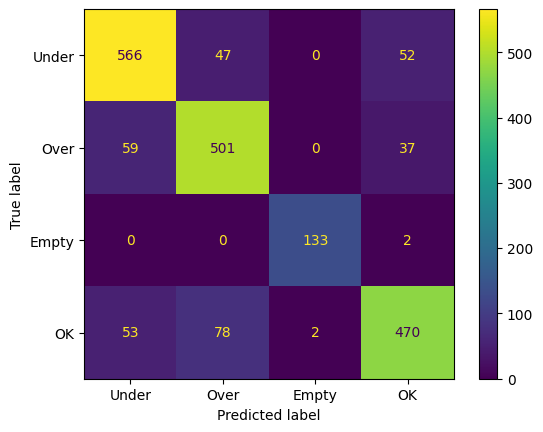

In [24]:
# Mostrar matriz de confusion
cf_matrix = confusion_matrix(y_true_val, y_pred_val) #Validacion o entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
disp.plot()
plt.show()

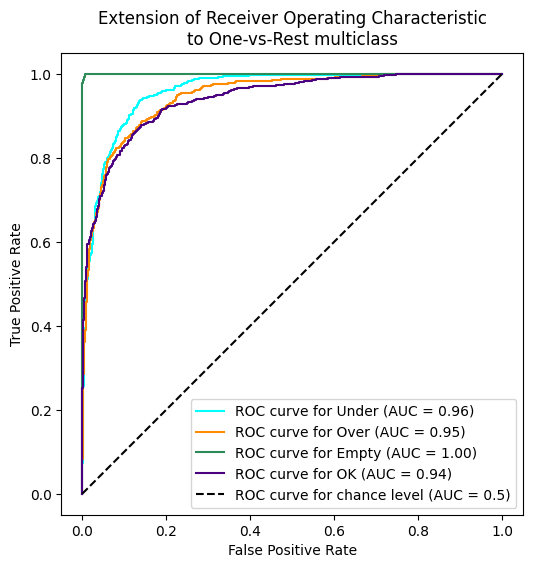

In [25]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

colors = cycle(["aqua", "darkorange", "seagreen","indigo"])
for class_id, color in zip(range(len(classes)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        yscore_val[:, class_id],
        name=f"ROC curve for {classes[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [26]:
class_dict = {0: 'Under', 1: 'Over', 2: 'Empty', 3: 'Ok'}
y_true_valnames = [(class_dict[label])
          for label in y_true_val
          if label in [0, 1, 2, 3]]

In [ ]:
from itertools import combinations


pair_list = list(combinations(np.unique(y_true_val), 2))
print(pair_list)

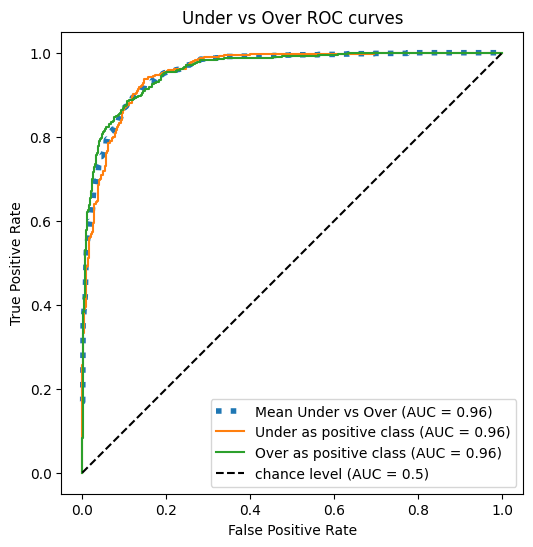

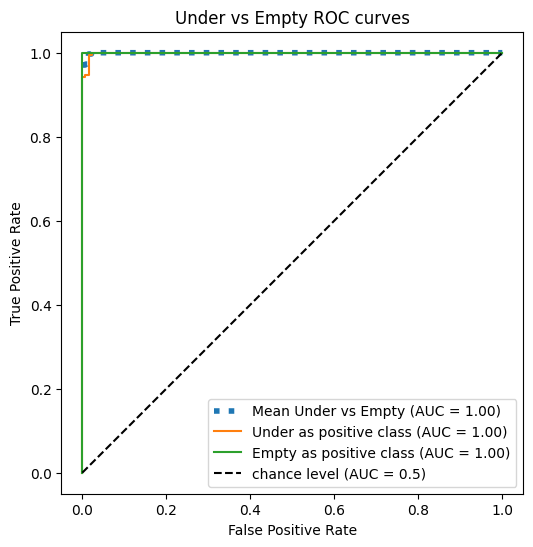

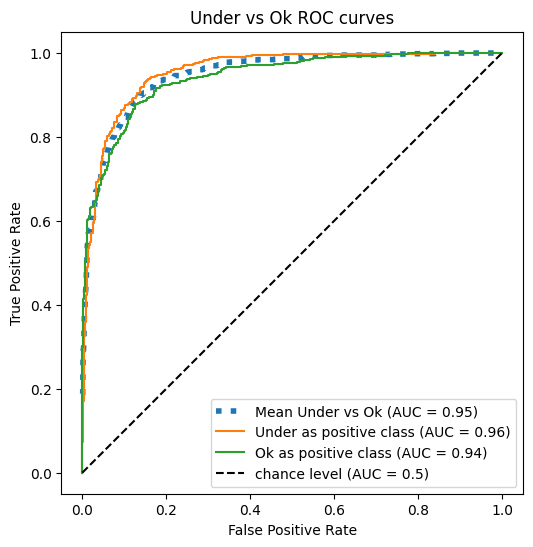

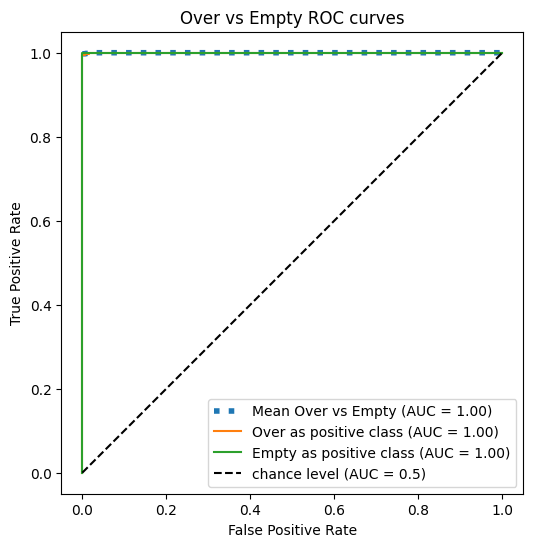

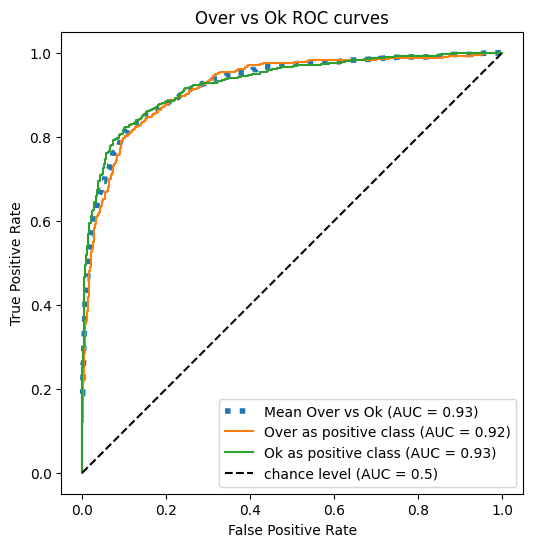

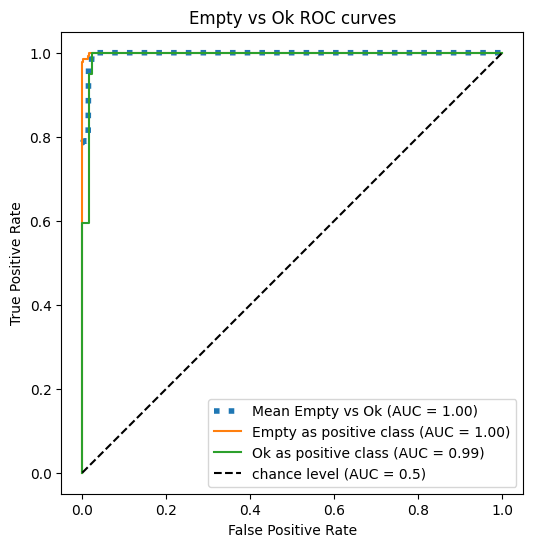

Macro-averaged One-vs-One ROC AUC score:
0.97


In [29]:
from sklearn.metrics import roc_curve, auc

pair_scores = []
mean_tpr = dict()
fpr_grid = np.linspace(0.0, 1.0, 1000)

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_true_val == label_a
    b_mask = y_true_val == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, yscore_val[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, yscore_val[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_dict[label_a]} vs {class_dict[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        yscore_val[ab_mask, idx_a],
        ax=ax,
        name=f"{class_dict[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        yscore_val[ab_mask, idx_b],
        ax=ax,
        name=f"{class_dict[label_b]} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{classes[idx_a]} vs {class_dict[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

## 2